In [270]:
from wordcloud import WordCloud, STOPWORDS
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import RSLPStemmer
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import codecs
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

**Leitura dos Arquivos e separando as Postagens e suas Classes**

In [271]:
dataset = pd.read_excel('Corpus Total.xlsx')
dataset.head()
classes= dataset['TIPO'].values
postagens = dataset['POSTAGEM'].values

In [272]:
dt = pd.read_excel('Corpus Total.xlsx')
dt.head()
cl= dt['TIPO'].values
post = dt['POSTAGEM'].values

In [273]:
#Conta a quantidade de linhas com o tipo Crítica    
dataset[dataset.TIPO=='Crítica; Comparação'].count()

N°                        13
POSTAGEM                  13
FUNCIONALIDADE             3
TIPO                      13
INTENÇÃO                   6
ANÁLISE DE SENTIMENTOS     6
USABILIDADE                5
UX                         3
ARTEFATO                   0
dtype: int64

In [274]:
postagens_str = ', '.join(postagens)
classes_str = ', '.join(classes)

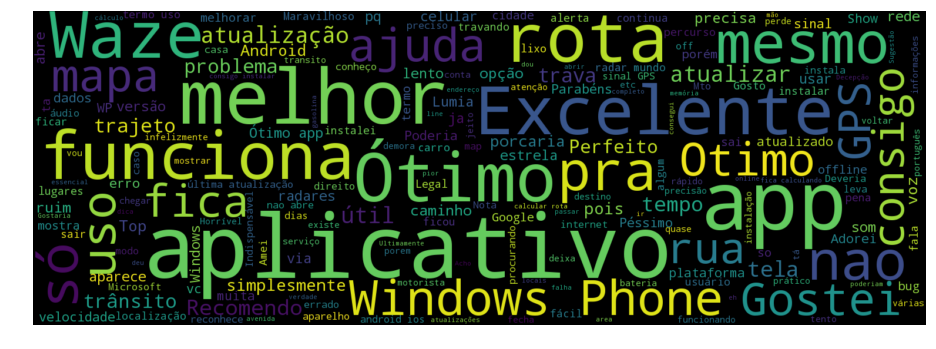

In [275]:
wordcloud = WordCloud(min_font_size= 9,max_font_size=150,width = 1520, height = 535, background_color='black',
                      stopwords=my_stopwords,random_state=1).generate(postagens_str)
plt.figure(figsize=(16,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [276]:
corpus_waze_playstore = [line.split('\n')[0] for line in codecs.open("CorpusWazePlayStore.txt",'r',encoding='utf-8')]
corpus_waze_windows = [line.split('\n')[0] for line in codecs.open("CorpusWazeWindowsStore.txt",'r',encoding='utf-8')]
corpus_maps_playstore = [line.split('\n')[0] for line in codecs.open("CorpusGoogleMapsPlayStore.txt",'r',encoding='utf-8')]
my_stopwords = [line.split('\r')[0] for line in codecs.open ("StopWords.txt",'r',encoding='utf-8')]
corpus_total = corpus_maps_playstore + corpus_waze_playstore + corpus_waze_windows

In [277]:
stopwords = nltk.corpus.stopwords.words('portuguese')

**Método que realiza o Steamming das Postagens**

In [278]:
stemmer = RSLPStemmer()
def stem_tokens(corpus, stemmer):
    stemmed = []
    for sentence in corpus:
        stemm_sent = ""
        tokens = nltk.word_tokenize(sentence)
        for item in tokens:
            stemm_sent = stemm_sent + stemmer.stem(item)+" "
        stemmed.append(stemm_sent)
    return stemmed


In [279]:
corpus_stemming = stem_tokens(postagens,stemmer)

**Transformação do Corpus num vetor de características utilizando o CountVectorizer**

In [280]:
vectorizer = CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        encoding='latin1', input= 'content',
        lowercase=True, max_df=0.95, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words= my_stopwords,
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer= None, vocabulary=None)

freq_corpus = vectorizer.fit_transform(corpus_stemming)
freq_corpus.shape

(1019, 529)

In [281]:
# features = vectorizer.get_feature_names()
# tot = np.array([freq_corpus])
#len(features)

**Métodos de Vizualização**

In [282]:
# for a in tot:
#     print(a)

In [283]:
# freq_corpus.toarray()[:500,0]

**Testes com o TfidfTransformer**

In [284]:
tf_transformer = TfidfTransformer(use_idf=False, smooth_idf=True, sublinear_tf=False).fit(freq_corpus)
X = tf_transformer.transform(freq_corpus)
#X.toarray()[23]

**Geração do Modelo**

In [285]:
modelo = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
modelo.fit(freq_corpus,classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Testando o Modelo de forma simples**

In [286]:
tests = ['aff','É bom Mas eventualmente a moça fica muda e não indica o caminho verbalmente'
,'Otimo','Ruim','app ruim','Melhor que o Waze','Excelente','Rápido, porém traça a rotas erradas']

In [287]:
freq_testes = vectorizer.transform(tests)

In [288]:
modelo.predict(freq_testes)

array(['Crítica', 'Crítica', 'Elogio', 'Crítica', 'Crítica', 'Elogio',
       'Elogio', 'Crítica'], 
      dtype='<U29')

**Avaliação do Modelo gerado**

In [289]:
# Fazendo o cross validation do modelo
resultados = cross_val_predict(modelo, freq_corpus, classes, cv =80)

C:\Users\Renan Lima\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=80.
  % (min_groups, self.n_splits)), Warning)


In [290]:
# Medindo a acurácia média do modelo
metrics.accuracy_score(classes,resultados,normalize=True)

0.81746810598626107

In [291]:
# Medidas de validação do modelo
# tipos=['Elogio','Crítica','Elogio; Sugestão','Crítica; Compração','Elogio; Crítica','Comparação']
tipos = ['Elogio','Crítica','Comparação','Sugestão','Crítica; Ajuda','Crítica; Comparação','Crítica; Dúvida','Crítica; Sugestão',
    'Elogio; Comparação','Elogio; Crítica','Elogio; Sugestão','Crítica; Comparação; Sugestão',
       'Dúvida','Elogio; Crítica; Comparação']
print (metrics.classification_report(classes,resultados,tipos))

                               precision    recall  f1-score   support

                       Elogio       0.88      0.95      0.92       509
                      Crítica       0.79      0.86      0.82       375
                   Comparação       0.50      0.17      0.25        12
                     Sugestão       0.60      0.59      0.59        41
               Crítica; Ajuda       0.00      0.00      0.00         1
          Crítica; Comparação       0.33      0.08      0.12        13
              Crítica; Dúvida       0.00      0.00      0.00         1
            Crítica; Sugestão       0.00      0.00      0.00         5
           Elogio; Comparação       0.00      0.00      0.00         4
              Elogio; Crítica       0.00      0.00      0.00        36
             Elogio; Sugestão       0.00      0.00      0.00        14
Crítica; Comparação; Sugestão       0.00      0.00      0.00         1
                       Dúvida       0.00      0.00      0.00         4
  Elo

C:\Users\Renan Lima\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [292]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito                        Comparação  Crítica  Crítica; Comparação  \
Real                                                                      
Comparação                              2        4                    0   
Critica                                 0        1                    0   
Crítica                                 1      321                    1   
Crítica; Ajuda                          0        1                    0   
Crítica; Comparação                     1        9                    1   
Crítica; Comparação; Sugestão           0        1                    0   
Crítica; Dúvida                         0        0                    0   
Crítica; Sugestão                       0        5                    0   
Dúvida                                  0        4                    0   
Elogio                                  0       22                    0   
Elogio; Comparação                      0        0                    0   
Elogio; Crítica          

**Gerando outro modelo de Teste**

In [293]:
vec = CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        encoding='latin1', input= 'content',
        lowercase=True, max_df=0.95, max_features=None, min_df=2,
        ngram_range=(1, 2), preprocessor=None, stop_words= my_stopwords,
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer= None, vocabulary=None)

freq = vec.fit_transform(corpus_stemming)
freq.shape

(1019, 951)

In [294]:
model = MultinomialNB()
model.fit(freq,classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [295]:
result = cross_val_predict(model, freq, classes, cv=120)

C:\Users\Renan Lima\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=120.
  % (min_groups, self.n_splits)), Warning)


In [296]:
metrics.accuracy_score(classes,result,normalize=True)

0.81452404317958782

In [297]:
print (metrics.classification_report(classes,result,tipos))

                               precision    recall  f1-score   support

                       Elogio       0.89      0.95      0.92       509
                      Crítica       0.80      0.87      0.83       375
                   Comparação       0.00      0.00      0.00        12
                     Sugestão       0.51      0.49      0.50        41
               Crítica; Ajuda       0.00      0.00      0.00         1
          Crítica; Comparação       0.00      0.00      0.00        13
              Crítica; Dúvida       0.00      0.00      0.00         1
            Crítica; Sugestão       0.00      0.00      0.00         5
           Elogio; Comparação       0.00      0.00      0.00         4
              Elogio; Crítica       0.00      0.00      0.00        36
             Elogio; Sugestão       0.00      0.00      0.00        14
Crítica; Comparação; Sugestão       0.00      0.00      0.00         1
                       Dúvida       0.00      0.00      0.00         4
  Elo

C:\Users\Renan Lima\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
